In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

eval_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_eval_videos'
os.makedirs(eval_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = [                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',

     
 'classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',

]

# Get vizualization for single session

In [4]:
sample_course = '05748A'
sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201904021630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05748A/classinsight-cmu_05748A_ghc_4101_201904021630-front'

In [5]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


4 16
9 36
11 25
17 36
26 28
Dict: eligible_id_map_dict
Key: Value


{16: 4, 17: 9, 25: 11, 28: 26, 36: 9}

Dict: eligible_id_map_dict
Key: Value


{16: 4, 17: 9, 25: 11, 28: 26, 36: 9}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 97:16 -->4
replacing 99:17 -->9
replacing 255:25 -->11
replacing 418:28 -->26
replacing 926:36 -->9
replacing 142:16 -->4
replacing 265:16 -->4
replacing 290:16 -->4
replacing 478:28 -->26
replacing 935:36 -->9
replacing 941:36 -->9


In [6]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [7]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,50328,50328
1,1,0,72015,72015
2,2,0,72015,72015
3,3,0,72015,72015
4,4,0,72015,72015
5,5,0,72015,72015
6,6,0,72015,72015
7,7,24,40485,40461
8,8,60,48618,48558
9,9,696,71760,71064


In [8]:
df_id_start_stop.total_idxs.max()*0.1

7201.5

In [13]:
INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.2
instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
instructor_ids

df_id_start_stop['presence_fraction'] = df_id_start_stop.total_idxs / df_id_start_stop.total_idxs.max()
filtered_ids = df_id_start_stop[df_id_start_stop.presence_fraction>0.5]['id'].values


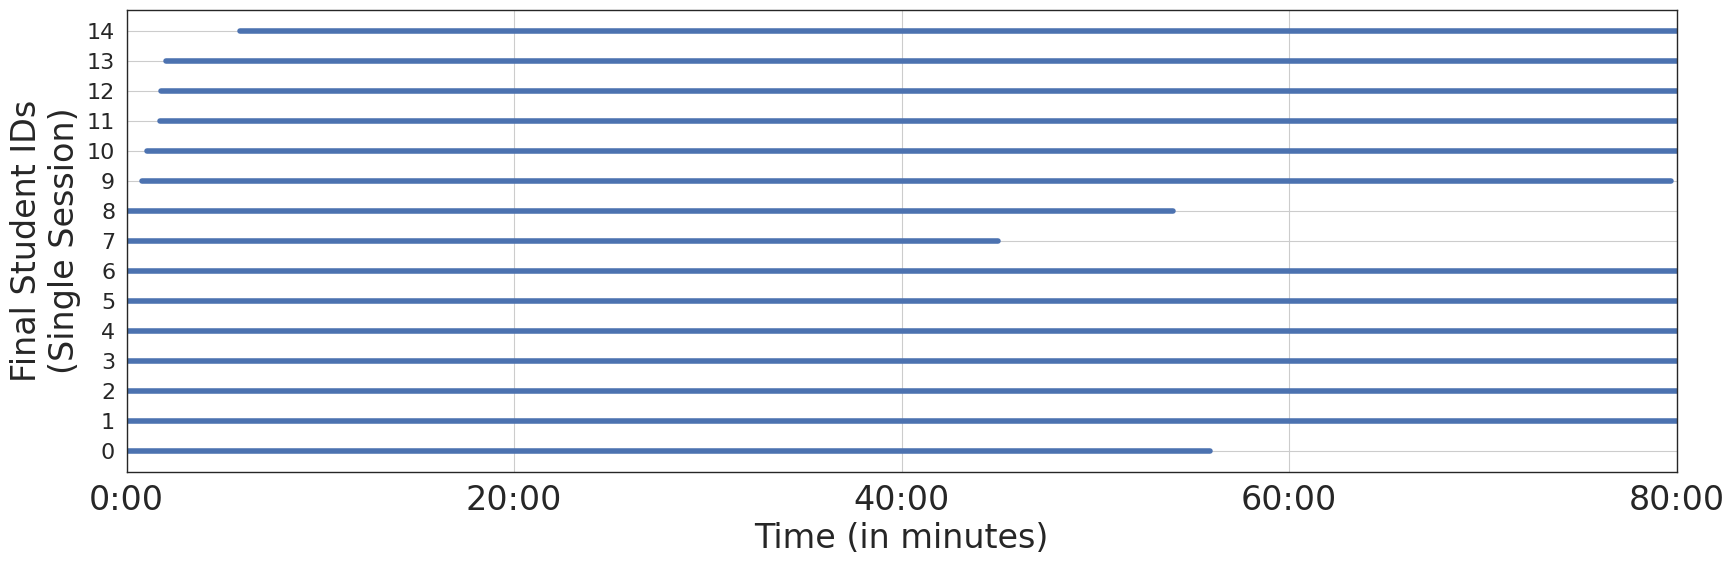

In [21]:
_ = plt.figure(figsize=(20,6))
y_ids = []
label_set=False
for row_idx, row in df_id_start_stop.sort_values(by='min_idx').iterrows():
    if row['id'] in filtered_ids:
        if not label_set:
            plt.axhline(y=len(y_ids), xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs, color='#4c72b0', linewidth=4, label='Student IDs')
            label_set=True
        else:
            plt.axhline(y=len(y_ids), xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs, color='#4c72b0', linewidth=4)
        y_ids.append(row['id'])        
label_set=False
# for row_idx, row in df_id_start_stop.iterrows():
#     if row['id'] in instructor_ids:
#         if not label_set:
#             plt.axhline(y=len(y_ids), xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs, color='#dd8452', linewidth=4, label='Instructor ID')
#             label_set=True
#         else:
#             plt.axhline(y=len(y_ids), xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs, color='#dd8452', linewidth=4)
#         y_ids.append(row['id'])

plt.yticks(range(len(y_ids)), range(len(y_ids)), fontsize=16)
plt.xlabel("Time (in minutes)", fontsize=24)
plt.ylabel("Final Student IDs\n(Single Session)", fontsize=24)
plt.xticks(np.arange(0,1.1,1/4), [f'{xr}:00' for xr in [0,20,40,60,80]], fontsize=24)
plt.grid() 
# plt.legend(fontsize=24)
plt.savefig('case_studies/plots/instructor_student.png', dpi=400, bbox_inches='tight') 

In [11]:
# find random frames to mark for GT from session
# np.random.seed(42)

MAX_SESSION_IDX = df_id_start_stop.max_idx.max()
NUM_SEGMENTS =3
SEG_START_MIN = 0.1
SEG_START_MAX=0.9
SET_SIZE = 60*15
SEGMENT_WINDOW_SIZE = (SEG_START_MAX - SEG_START_MIN)/NUM_SEGMENTS

session_frames = df_tracking_new.index.values.tolist()
selected_frames = []
selected_sets = []

for i in range(NUM_SEGMENTS):    
    seg_window =  np.arange(int((SEG_START_MIN + (i*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX), int((SEG_START_MIN + ((i+1)*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX) - SET_SIZE) 
    seg_set_start = np.random.choice(seg_window)
    seg_set_end = seg_set_start+SET_SIZE
    segment_frames = [xr for xr in session_frames if ((xr >= seg_set_start) and (xr<seg_set_end))]
    selected_sets.append((seg_set_start, seg_set_end, segment_frames))
    selected_frames+=segment_frames        

sprint(selected_sets)

List: selected_sets


[
    (
        21324,
        22224,
        [
            21324,
            21327,
            21330,
            21333,
            21336,
            21339,
            21342,
            21345,
            21348,
            21351,
            21354,
            21357,
            21360,
            21363,
            21366,
            21369,
            21372,
            21375,
            21378,
            21381,
            21384,
            21387,
            21390,
            21393,
            21396,
            21399,
            21402,
            21405,
            21408,
            21411,
            21414,
            21417,
            21420,
            21423,
            21426,
            21429,
            21432,
            21435,
            21438,
            21441,
            21444,
            21447,
            21450,
            21453,
            21456,
            21459,
            21462,
            21465,
            21468,
            21471,
            21474,
            21477,
            21480,
            21483,
            21486,
            21489,
            21492,
            21495,
            21498,
            21501,
            21504,
            21507,
            21510,
            21513,
            21516,
            21519,
            21522,
            21525,
            21528,
            21531,
            21534,
            21537,
            21540,
            21543,
            21546,
            21549,
            21552,
            21555,
            21558,
            21561,
            21564,
            21567,
            21570,
            21573,
            21576,
            21579,
            21582,
            21585,
            21588,
            21591,
            21594,
            21597,
            21600,
            21603,
            21606,
            21609,
            21612,
            21615,
            21618,
            21621,
            21624,
            21627,
            21630,
            21633,
            21636,
            21639,
            21642,
            21645,
            21648,
            21651,
            21654,
            21657,
            21660,
            21663,
            21666,
            21669,
            21672,
            21675,
            21678,
            21681,
            21684,
            21687,
            21690,
            21693,
            21696,
            21699,
            21702,
            21705,
            21708,
            21711,
            21714,
            21717,
            21720,
            21723,
            21726,
            21729,
            21732,
            21735,
            21738,
            21741,
            21744,
            21747,
            21750,
            21753,
            21756,
            21759,
            21762,
            21765,
            21768,
            21771,
            21774,
            21777,
            21780,
            21783,
            21786,
            21789,
            21792,
            21795,
            21798,
            21801,
            21804,
            21807,
            21810,
            21813,
            21816,
            21819,
            21822,
            21825,
            21828,
            21831,
            21834,
            21837,
            21840,
            21843,
            21846,
            21849,
            21852,
            21855,
            21858,
            21861,
            21864,
            21867,
            21870,
            21873,
            21876,
            21879,
            21882,
            21885,
            21888,
            21891,
            21894,
            21897,
            21900,
            21903,
            21906,
            21909,
            21912,
            21915,
            21918,
            21921,
            21924,
            21927,
            21930,
            21933,
            21936,
            21939,
            21942,
            21945,


In [12]:
len(selected_frames)

900

In [13]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:0',
}


In [14]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xae85480] error while decoding MB 69 34, bytestream -15
[h264 @ 0x9fc4e00] error while decoding MB 69 34, bytestream -15
[h264 @ 0xa247600] error while decoding MB 179 94, bytestream -7
[h264 @ 0x9fc4e00] error while decoding MB 69 34, bytestream -15
[h264 @ 0xa247600] error while decoding MB 179 94, bytestream -7


Looped 0 images


[h264 @ 0xa153640] error while decoding MB 139 64, bytestream -5
[h264 @ 0xa220f00] error while decoding MB 156 61, bytestream -5
[h264 @ 0xefff780] error while decoding MB 167 65, bytestream -15
[h264 @ 0xa25ba00] error while decoding MB 221 64, bytestream -7
[h264 @ 0xa2acdc0] error while decoding MB 223 62, bytestream -11
[h264 @ 0xa2d5840] error while decoding MB 10 64, bytestream -7
[h264 @ 0xa153640] error while decoding MB 166 66, bytestream -5
[h264 @ 0xa220f00] error while decoding MB 12 66, bytestream -5
[h264 @ 0xefff780] error while decoding MB 136 65, bytestream -5


Looped 10000 images


[h264 @ 0xa25ba00] error while decoding MB 183 76, bytestream -5
[h264 @ 0xa2acdc0] error while decoding MB 8 60, bytestream -5
[h264 @ 0xa2d5840] error while decoding MB 18 73, bytestream -5
[h264 @ 0xa153640] error while decoding MB 126 45, bytestream -11
[h264 @ 0xa220f00] error while decoding MB 178 43, bytestream -15
[h264 @ 0xefff780] error while decoding MB 17 49, bytestream -5
[h264 @ 0xf027f80] error while decoding MB 173 54, bytestream -9
[h264 @ 0xa25ba00] error while decoding MB 16 48, bytestream -5
[h264 @ 0xa2acdc0] error while decoding MB 126 48, bytestream -11
[h264 @ 0xa2d5840] error while decoding MB 75 44, bytestream -5
[h264 @ 0xa153640] error while decoding MB 127 41, bytestream -11
[h264 @ 0xa220f00] error while decoding MB 57 41, bytestream -5
[h264 @ 0xefff780] error while decoding MB 54 45, bytestream -7
[h264 @ 0xa25ba00] error while decoding MB 132 46, bytestream -9
[h264 @ 0xa2acdc0] error while decoding MB 72 50, bytestream -5
[h264 @ 0xa2d5840] error while

Looped 20000 images


[h264 @ 0xae8bf80] error while decoding MB 15 94, bytestream -5
[h264 @ 0x9fc4e00] error while decoding MB 190 93, bytestream -26
[h264 @ 0xa235300] error while decoding MB 177 101, bytestream -19
[h264 @ 0xf013b80] error while decoding MB 61 101, bytestream -16
[h264 @ 0xa247600] error while decoding MB 50 99, bytestream -13
[h264 @ 0xa26fe00] error while decoding MB 66 85, bytestream -13
[h264 @ 0xa2c1300] error while decoding MB 225 92, bytestream -6
[h264 @ 0xae8bf80] error while decoding MB 98 38, bytestream -23
[h264 @ 0x9fc4e00] error while decoding MB 49 86, bytestream -20
[h264 @ 0xa235300] error while decoding MB 179 94, bytestream -17
[h264 @ 0xf013b80] error while decoding MB 178 95, bytestream -28
[h264 @ 0xa247600] error while decoding MB 111 85, bytestream -15
[h264 @ 0xa26fe00] error while decoding MB 233 90, bytestream -10
[h264 @ 0xa298880] error while decoding MB 239 125, bytestream -22
[h264 @ 0xa2c1300] error while decoding MB 99 93, bytestream -21
[h264 @ 0xae8bf8

Looped 30000 images


[h264 @ 0x9fc4e00] error while decoding MB 224 8, bytestream -24
[h264 @ 0xa235300] error while decoding MB 84 82, bytestream -7
[h264 @ 0xf013b80] error while decoding MB 177 92, bytestream -9
[h264 @ 0xa247600] error while decoding MB 193 60, bytestream -12
[h264 @ 0xa26fe00] error while decoding MB 51 83, bytestream -16
[h264 @ 0xa298880] error while decoding MB 132 90, bytestream -23
[h264 @ 0xa2c1300] error while decoding MB 176 83, bytestream -12
[h264 @ 0xae8bf80] error while decoding MB 210 72, bytestream -7
[h264 @ 0x9fc4e00] error while decoding MB 152 72, bytestream -7
[h264 @ 0xa235300] error while decoding MB 96 75, bytestream -16
[h264 @ 0xf013b80] error while decoding MB 40 62, bytestream -8
[h264 @ 0xa247600] error while decoding MB 7 57, bytestream -20
[h264 @ 0xa26fe00] error while decoding MB 45 44, bytestream -33
[h264 @ 0xa298880] error while decoding MB 109 30, bytestream -25
[h264 @ 0xa2c1300] error while decoding MB 185 47, bytestream -22
[h264 @ 0xae8bf80] erro

Looped 40000 images


[h264 @ 0xa2c1300] error while decoding MB 84 46, bytestream -12
[h264 @ 0xae8bf80] error while decoding MB 104 44, bytestream -16
[h264 @ 0x9fc4e00] error while decoding MB 166 26, bytestream -15
[h264 @ 0xa235300] error while decoding MB 207 43, bytestream -5
[h264 @ 0xf013b80] error while decoding MB 93 17, bytestream -36
[h264 @ 0xa247600] error while decoding MB 33 24, bytestream -16
[h264 @ 0xa26fe00] error while decoding MB 89 46, bytestream -25
[h264 @ 0xa298880] error while decoding MB 82 22, bytestream -10
[h264 @ 0xa2c1300] error while decoding MB 190 29, bytestream -25
[h264 @ 0xae8bf80] error while decoding MB 224 6, bytestream -6
[h264 @ 0x9fc4e00] error while decoding MB 152 101, bytestream -28
[h264 @ 0xa235300] error while decoding MB 116 108, bytestream -24
[h264 @ 0xf013b80] error while decoding MB 104 116, bytestream -26
[h264 @ 0xa247600] error while decoding MB 179 108, bytestream -22
[h264 @ 0xa26fe00] error while decoding MB 75 108, bytestream -21
[h264 @ 0xa2ac

Looped 50000 images


[h264 @ 0xa298880] error while decoding MB 70 126, bytestream -8
[h264 @ 0xa2c1300] error while decoding MB 158 100, bytestream -18
[h264 @ 0xae8bf80] error while decoding MB 175 100, bytestream -30
[h264 @ 0x9fc4e00] error while decoding MB 123 100, bytestream -8
[h264 @ 0xa235300] error while decoding MB 120 101, bytestream -24
[h264 @ 0xf013b80] error while decoding MB 201 98, bytestream -14
[h264 @ 0xa247600] error while decoding MB 58 91, bytestream -16
[h264 @ 0xa26fe00] error while decoding MB 106 100, bytestream -23
[h264 @ 0xa298880] error while decoding MB 229 123, bytestream -10
[h264 @ 0xa2c1300] error while decoding MB 30 93, bytestream -7
[h264 @ 0xae8bf80] error while decoding MB 58 87, bytestream -17
[h264 @ 0x9fc4e00] error while decoding MB 133 93, bytestream -12
[h264 @ 0xa235300] error while decoding MB 158 93, bytestream -24
[h264 @ 0xf013b80] error while decoding MB 142 91, bytestream -30
[h264 @ 0xa247600] error while decoding MB 91 91, bytestream -7
[h264 @ 0xa2

Looped 60000 images


[h264 @ 0xa247600] error while decoding MB 129 83, bytestream -21
[h264 @ 0xa26fe00] error while decoding MB 101 69, bytestream -12
[h264 @ 0xa298880] error while decoding MB 132 79, bytestream -8
[h264 @ 0xa2c1300] error while decoding MB 8 68, bytestream -20
[h264 @ 0xae8bf80] error while decoding MB 53 75, bytestream -20
[h264 @ 0x9fc4e00] error while decoding MB 71 69, bytestream -14
[h264 @ 0xa235300] error while decoding MB 206 62, bytestream -31
[h264 @ 0xf013b80] error while decoding MB 22 55, bytestream -15
[h264 @ 0xa247600] error while decoding MB 85 32, bytestream -19
[h264 @ 0xa26fe00] error while decoding MB 218 62, bytestream -36
[h264 @ 0xa298880] error while decoding MB 26 40, bytestream -10
[h264 @ 0xa2c1300] error while decoding MB 134 46, bytestream -14
[h264 @ 0xae8bf80] error while decoding MB 104 47, bytestream -22
[h264 @ 0x9fc4e00] error while decoding MB 108 84, bytestream -15
[h264 @ 0xa235300] error while decoding MB 117 33, bytestream -6
[h264 @ 0xf013b80] 

Looped 70000 images


[h264 @ 0xa235300] error while decoding MB 160 101, bytestream -26
[h264 @ 0xf013b80] error while decoding MB 40 108, bytestream -5
[h264 @ 0xa247600] error while decoding MB 112 106, bytestream -9
[h264 @ 0xa26fe00] error while decoding MB 62 110, bytestream -25
[h264 @ 0xa2acdc0] error while decoding MB 133 44, bytestream -5
[h264 @ 0xa2c1300] error while decoding MB 99 101, bytestream -20
[h264 @ 0xae8bf80] error while decoding MB 103 102, bytestream -13
[h264 @ 0x9fc4e00] error while decoding MB 103 109, bytestream -20
[h264 @ 0xa235300] error while decoding MB 152 100, bytestream -12
[h264 @ 0xf013b80] error while decoding MB 100 108, bytestream -25
[h264 @ 0xa247600] error while decoding MB 190 101, bytestream -16
[h264 @ 0xa26fe00] error while decoding MB 52 116, bytestream -9
[h264 @ 0xa2acdc0] error while decoding MB 157 35, bytestream -9
[h264 @ 0xa2c1300] error while decoding MB 111 100, bytestream -31
[h264 @ 0xae8bf80] error while decoding MB 142 100, bytestream -10
[h264 

Looped 80000 images


[h264 @ 0xae8bf80] error while decoding MB 62 95, bytestream -12
[h264 @ 0x9fc4e00] error while decoding MB 98 101, bytestream -17
[h264 @ 0xa235300] error while decoding MB 209 93, bytestream -19
[h264 @ 0xf013b80] error while decoding MB 145 100, bytestream -10
[h264 @ 0xa247600] error while decoding MB 154 79, bytestream -20
[h264 @ 0xa26fe00] error while decoding MB 89 108, bytestream -6
[h264 @ 0xa298880] error while decoding MB 56 118, bytestream -35
[h264 @ 0xa2c1300] error while decoding MB 177 94, bytestream -24
[h264 @ 0xae8bf80] error while decoding MB 27 93, bytestream -5
[h264 @ 0x9fc4e00] error while decoding MB 137 101, bytestream -25
[h264 @ 0xa235300] error while decoding MB 110 92, bytestream -20
[h264 @ 0xf013b80] error while decoding MB 199 91, bytestream -20
[h264 @ 0xa247600] error while decoding MB 150 92, bytestream -18
[h264 @ 0xa26fe00] error while decoding MB 152 99, bytestream -17
[h264 @ 0xa298880] error while decoding MB 51 110, bytestream -24
[h264 @ 0xa2

Looped 90000 images


[h264 @ 0xa2c1300] error while decoding MB 204 66, bytestream -8
[h264 @ 0xae8bf80] error while decoding MB 146 66, bytestream -6
[h264 @ 0x9fc4e00] error while decoding MB 90 75, bytestream -16
[h264 @ 0xa235300] error while decoding MB 200 61, bytestream -17
[h264 @ 0xf013b80] error while decoding MB 95 59, bytestream -45
[h264 @ 0xa247600] error while decoding MB 163 46, bytestream -24
[h264 @ 0xa26fe00] error while decoding MB 155 72, bytestream -16
[h264 @ 0xa298880] error while decoding MB 80 87, bytestream -18
[h264 @ 0xa2c1300] error while decoding MB 19 52, bytestream -17
[h264 @ 0xae8bf80] error while decoding MB 214 70, bytestream -8
[h264 @ 0xa247600] cabac decode of qscale diff failed at 151 43
[h264 @ 0xa247600] error while decoding MB 151 43, bytestream 433480
[h264 @ 0x9fc4e00] error while decoding MB 133 47, bytestream -40
[h264 @ 0xa235300] error while decoding MB 115 109, bytestream -5
[h264 @ 0xf013b80] error while decoding MB 233 108, bytestream -12
[h264 @ 0xa2476

In [15]:
import cv2
session_id_viz_dir = f'{eval_viz_cache_root}/{sample_session_id}'
font = cv2.FONT_HERSHEY_DUPLEX
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, segment_frames) in enumerate(selected_sets):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                new_id = old_to_new_id_map[old_id]
                if new_id in instructor_ids:
                    new_id = 1000+new_id
                frame_tracking_results[person_idx]['track_id'] =new_id
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_img = cv2.putText(frame_img,
                   f'frame_idx:{frame_idx}',
                   (frame_img.shape[1]//2, frame_img.shape[0]//2+1000),
                   font, 2,
                   (255, 255, 255),
                   2)
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
                # cv2.imwrite(f'frame_test/{frame_idx}.jpg',frame_track_img)
            else:
                cv2.imwrite(frame_file_out,frame_img)
                
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=10, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-11-14 12:19:47,995 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-11-14 12:19:48,684 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-11-14 12:19:48,688 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 12:19:48,689 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 12:19:50,351 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector